# Data engineer test project

My first Jupyter Notebook!

A cruft-free as possible... but I left in the commented code that should subset the original dataset, which I couldn't get to complete locally.

Thanks for your consideration!

-ck

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
sns.set(style="darkgrid")

# File downloader convenience
def download_file(url, local=False):
    local_filename = url.split('/')[-1] if not local else local
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)
    return local_filename

In [48]:
# # Full 311 dataset
# filename = './data/rows.csv'
# file = Path(filename)
# if not file.is_file():
#     url = 'https://data.cityofnewyork.us/api/views/erm2-nwe9/rows.csv'
#     download_file(url, filename)

# dtype = {
#     'Unique Key': 'int64',
#     'Created Date': 'str',
#     'Closed Date': 'str',
#     'Agency': 'str',
#     'Agency Name': 'str',
#     'Complaint Type': 'str',
#     'Descriptor': 'str',
#     'Location Type': 'str',
#     'Incident Zip': 'str',
#     'Incident Address': 'str',
#     'Street Name': 'str',
#     'Cross Street 1': 'str',
#     'Cross Street 2': 'str',
#     'Intersection Street 1': 'str',
#     'Intersection Street 2': 'str',
#     'Address Type': 'str',
#     'City': 'str',
#     'Landmark': 'str',
#     'Facility Type': 'str',
#     'Status': 'str',
#     'Due Date': 'str',
#     'Resolution Description': 'str',
#     'Resolution Action Updated Date': 'str',
#     'Community Board': 'str',
#     'BBL': 'float64',
#     'Borough': 'str',
#     'X Coordinate (State Plane)': 'float64',
#     'Y Coordinate (State Plane)': 'float64',
#     'Open Data Channel Type': 'str',
#     'Park Facility Name': 'str',
#     'Park Borough': 'str',
#     'Vehicle Type': 'str',
#     'Taxi Company Borough': 'str',
#     'Taxi Pick Up Location': 'str',
#     'Bridge Highway Name': 'str',
#     'Bridge Highway Direction': 'str',
#     'Road Ramp': 'str',
#     'Bridge Highway Segment': 'str',
#     'Latitude': 'float64',
#     'Longitude': 'float64',
#     'Location': 'str'}

# usecols = [
#     'Unique Key',
#     'Created Date',
#     'Complaint Type',
#     'Incident Zip',
#     'City',
#     'Borough',
# ]

# rename_cols = [
#     'unique_key',
#     'created_date',
#     'complaint_type',
#     'incident_zip',
#     'city',
#     'borough',
# ]

# reorder_cols = [
#     'unique_key',
#     'created_date',
#     'borough',
#     'incident_zip',
#     'city',
#     'complaint_type',
# ]

# # For full data set -- too memory/time intensive for my machine, but should work in theory...
# parse_dates = ['Created Date']
    
# df = pd.read_csv(filename, engine='c', dtype=dtype, usecols=usecols, infer_datetime_format=True, parse_dates=parse_dates)

# iter_csv = pd.read_csv(filename, iterator=True, chunksize=1000, usecols=usecols, dtype=dtype, infer_datetime_format=True, parse_dates=parse_dates)
# df = pd.concat([chunk[chunk['Created Date'] > '2016'] for chunk in iter_csv])

# # Make cleaned up data like the provided subset
# df = pd.read_csv(filename, dtype=dtype, usecols=usecols)
# df.columns = rename_cols
# df = df[reorder_cols]

In [49]:
# For the already subset 2017 data
subset_dtype = {
    'unique_key': 'int64',
    'created_date': 'str',
    'borough': 'str',
    'incident_zip': 'str',
    'city': 'str',
    'borough': 'str'}

subset_filename = './data/2017_subset.csv'
subset_file = Path(subset_filename)
if not subset_file.is_file():
    url = 'https://s3.amazonaws.com/dbrs-recruit/2017_subset.csv'
    download_file(url, subset_filename)
df = pd.read_csv(subset_filename, dtype=subset_dtype)

# Load the population DataFrame
rename_zip_pop_cols = [
    'incident_zip',
    'zip_pop'
]
zip_pop_filename = './data/zip_pop.csv'
zip_pop_file = Path(zip_pop_filename)
if not zip_pop_file.is_file():
    zip_pop_url = 'https://s3.amazonaws.com/SplitwiseBlogJB/2010+Census+Population+By+Zipcode+(ZCTA).csv'
    download_file(zip_pop_url, zip_pop_filename)
    
zip_pop = pd.read_csv(zip_pop_filename)
zip_pop.columns = rename_zip_pop_cols

### Clean up Unspecified boroughs (bonus)

I grabbed a list of zips by NYC borough from [here](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php) and cleaned it up manually

Skip to compare with raw data

In [50]:
# Load the zip-to-borough DataFrame for unspecified boroughs cleanup
zip_borough_filename = './data/zip_borough.csv'
zip_borough = pd.read_csv(zip_borough_filename)

# Make sure all zips are numeric, drop rows that aren't for now
df['incident_zip'] = pd.to_numeric(df['incident_zip'], downcast='integer', errors='coerce')
df = df.dropna(subset=['incident_zip'])

# Change the zip column back to an int
cols = ['incident_zip']
df[cols] = df[cols].applymap(np.int64)

# Add the borough by zip column
df = df.merge(zip_borough, how='left', on=['incident_zip'])

# If we find an unspecified borough, update it from the borough by zip column
df['borough'] = df.apply(lambda x: x['zip_borough'] if x['borough'] == 'Unspecified' else x['borough'], axis=1)

In [51]:
# Get the top 10 complaint types
top_complaints = df.complaint_type.value_counts().nlargest(10)
top_complaints

Noise - Residential        229858
HEAT/HOT WATER             213477
Illegal Parking            145533
Blocked Driveway           135570
Street Condition            90377
UNSANITARY CONDITION        79260
Noise - Street/Sidewalk     72901
Water System                63691
Noise                       59466
PAINT/PLASTER               57069
Name: complaint_type, dtype: int64

## Question 1

Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017?

In [52]:
# Create a new DataFrame that only includes complaints in the top 10 types
tc = df[df['complaint_type'].isin(top_complaints.index)]

# Group by borough and type
gb = tc.groupby(['borough', 'complaint_type'])

# Get counts of each type within group
counts = gb.size().to_frame(name='count')

# Sort by count descending
counts.reset_index().sort_values(['borough','count'], ascending=False).set_index(['borough','complaint_type'])

count
borough       complaint_type                
STATEN ISLAND Street Condition         10351
              Illegal Parking           8060
              Noise - Residential       7037
              Water System              5273
              Blocked Driveway          3794
              HEAT/HOT WATER            2073
              UNSANITARY CONDITION      1951
              Noise                     1906
              PAINT/PLASTER             1010
              Noise - Street/Sidewalk    867
QUEENS        Blocked Driveway         54367
              Noise - Residential      46415
              Illegal Parking          46134
              Street Condition         29499
              HEAT/HOT WATER           29186
              Water System             18279
              UNSANITARY CONDITION     11467
              Noise                    10523
              Noise - Street/Sidewalk   7532
              PAINT/PLASTER             5682
MANHATTAN     Noise - Residential      51055
              HEAT/HOT WATER           46528
              Noise - Street/Sidewalk  29156
              Noise                    28754
              Illegal Parking          19734
              UNSANITARY CONDITION     14631
              Street Condition         14497
              PAINT/PLASTER            11486
              Water System             10666
              Blocked Driveway          3431
BROOKLYN      Noise - Residential      67663
              HEAT/HOT WATER           66977
              Illegal Parking          55469
              Blocked Driveway         49386
              UNSANITARY CONDITION     26654
              Street Condition         24875
              Noise - Street/Sidewalk  21317
              Water System             19508
              PAINT/PLASTER            19398
              Noise                    15227
BRONX         HEAT/HOT WATER           68713
              Noise - Residential      57687
              Blocked Driveway         24592
              UNSANITARY CONDITION     24557
              PAINT/PLASTER            19493
              Illegal Parking          16136
              Noise - Street/Sidewalk  14028
              Street Condition         11155
              Water System              9965
              Noise                     3056

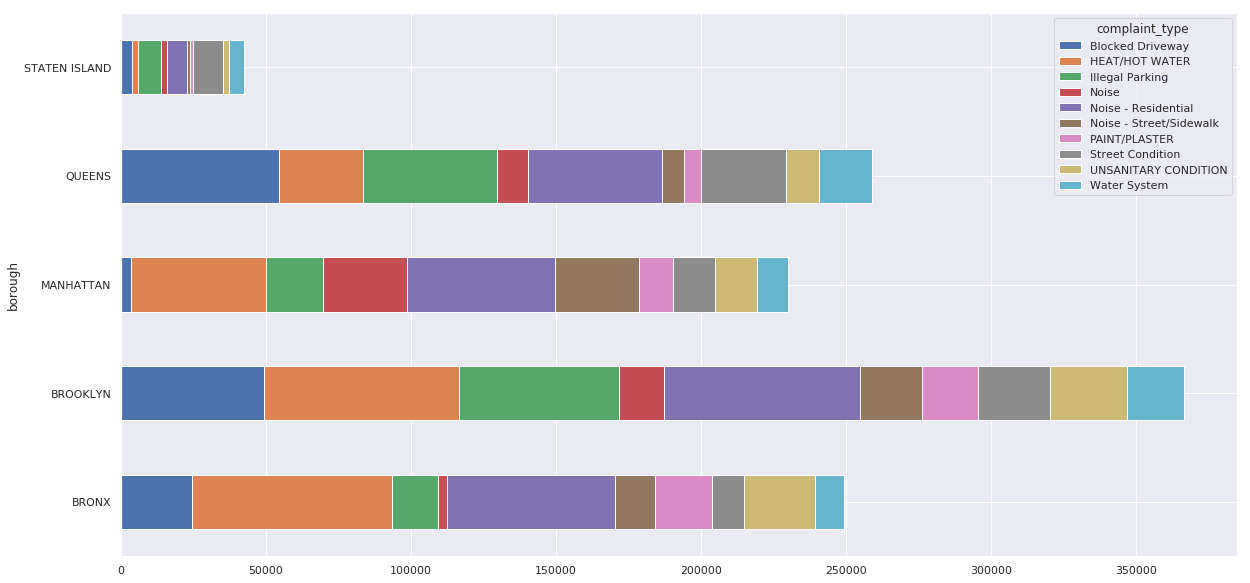

In [53]:
counts.pivot_table(index='borough', columns='complaint_type', values='count').plot(kind='barh', stacked=True, figsize=(20,10))

## Question 2

Consider only the 10 most common overall complaint types.  For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?

In [54]:
# Copy the top complaints limited DataFrame
tc2 = tc.copy()

# Make sure all zips are numeric, drop rows that aren't for now
tc2['incident_zip'] = pd.to_numeric(tc2['incident_zip'], downcast='integer', errors='coerce')
tc2 = tc2.dropna(subset=['incident_zip'])

# Change the zip column back to an int
cols = ['incident_zip']
tc2[cols] = tc2[cols].applymap(np.int64)

# Merge the population by zip data
tc_pop = tc2.merge(zip_pop, how='left', on=['incident_zip'])

# Get the top 10 unique zips by population from the top complaints DataFrame
cols = ['incident_zip', 'zip_pop']
top_zip_pop = tc_pop[cols].drop_duplicates().nlargest(10, 'zip_pop')['incident_zip'].values

# Make a new DF that is only rows in the top 10 zips by population
tczp = tc_pop[tc_pop['incident_zip'].isin(top_zip_pop)]

# Group them by zip and complaint type
gb = tczp.groupby(['incident_zip', 'complaint_type'])

# Count the occurances
counts = gb.size().to_frame(name='count')

# Sort and clean up
counts.reset_index().sort_values(['incident_zip','count'], ascending=False).set_index(['incident_zip','complaint_type'])

count
incident_zip complaint_type                
11385        Illegal Parking           4135
             Blocked Driveway          3042
             Noise - Residential       2609
             HEAT/HOT WATER            1526
             Water System              1240
             Street Condition          1232
             UNSANITARY CONDITION       647
             Noise - Street/Sidewalk    607
             Noise                      507
             PAINT/PLASTER              352
11373        HEAT/HOT WATER            3408
             Blocked Driveway          2635
             Noise - Residential       1842
             Illegal Parking           1277
             UNSANITARY CONDITION       756
             Street Condition           691
             Water System               372
             Noise - Street/Sidewalk    304
             Noise                      270
             PAINT/PLASTER              265
11368        Blocked Driveway          4384
             Noise - Residential       2460
             HEAT/HOT WATER            1620
             Illegal Parking           1251
             Noise - Street/Sidewalk    684
             UNSANITARY CONDITION       639
             Water System               617
             Street Condition           561
             PAINT/PLASTER              361
             Noise                      158
...                                     ...
11207        Noise - Residential       3061
             HEAT/HOT WATER            2461
             Blocked Driveway          2062
             UNSANITARY CONDITION      1621
             Illegal Parking           1500
             Street Condition          1142
             PAINT/PLASTER             1055
             Water System               757
             Noise - Street/Sidewalk    558
             Noise                      199
10467        HEAT/HOT WATER            6041
             Noise - Residential       5807
             UNSANITARY CONDITION      2192
             Blocked Driveway          2068
             PAINT/PLASTER             1955
             Illegal Parking            986
             Noise - Street/Sidewalk    713
             Street Condition           612
             Water System               560
             Noise                      285
10025        HEAT/HOT WATER            2397
             Noise - Residential       2085
             Noise                     1398
             Noise - Street/Sidewalk   1224
             Illegal Parking            736
             UNSANITARY CONDITION       714
             Street Condition           628
             PAINT/PLASTER              604
             Water System               481
             Blocked Driveway           125

[100 rows x 1 columns]

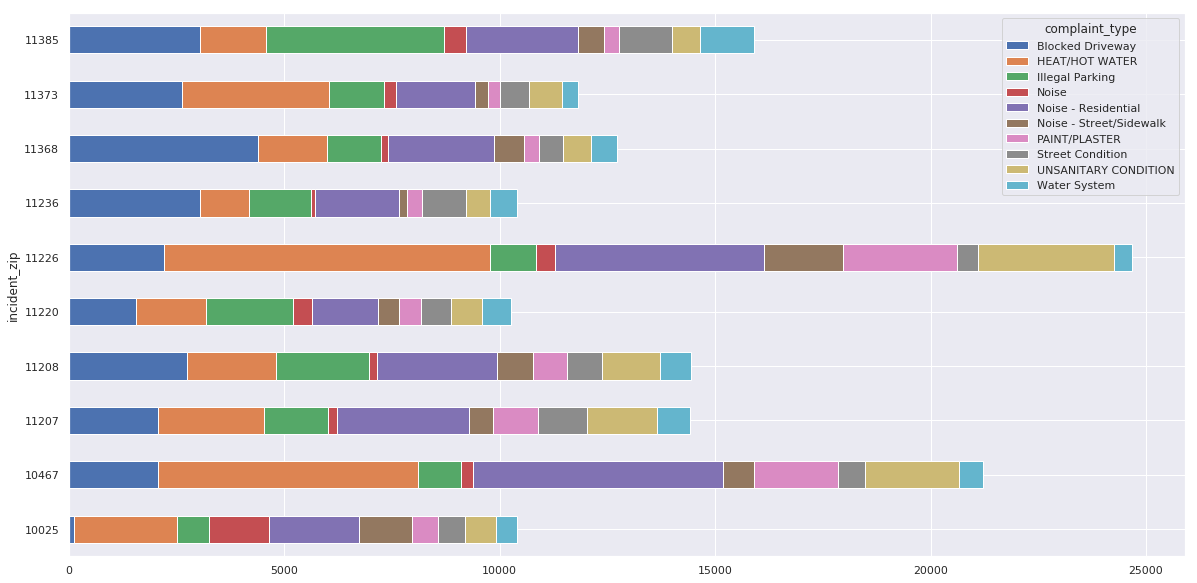

In [55]:
counts.pivot_table(index='incident_zip', columns='complaint_type', values='count').plot(kind='barh', stacked=True, figsize=(20,10))

## Question 3

Considering all complaint types. Which boroughs are the biggest "complainers" relative to the size of the population in 2017? Meaning, calculate a complaint-index that adjusts for population of the borough.

In [56]:
# Make a copy for safety
df2 = df.copy()

# Make sure all zips are numeric, drop rows that aren't for now
df2['incident_zip'] = pd.to_numeric(df2['incident_zip'], downcast='integer', errors='coerce')
df2 = df2.dropna(subset=['incident_zip'])

# Change the zip column back to an int
cols = ['incident_zip']
df2[cols] = df2[cols].applymap(np.int64)

# Merge in the population data again
df_pop = df2.merge(zip_pop, how='left', on=['incident_zip'])

**There's probably a quicker way to do this than creating two Series and concatenating them into a DataFrame, but I'm still learning...**

In [57]:
# Get the borough populations by summing the unique zipcodes in each
bor_pop = df_pop.drop_duplicates(['borough', 'incident_zip', 'zip_pop']).groupby('borough')['zip_pop'].agg('sum')
bor_pop

borough
BRONX            1592084.0
BROOKLYN         2732303.0
MANHATTAN        2073659.0
QUEENS           2755424.0
STATEN ISLAND     468730.0
Name: zip_pop, dtype: float64

In [58]:
# Get the complaints per borough
bor_comp = df_pop.groupby('borough')['unique_key'].count()
bor_comp

borough
BRONX            433083
BROOKLYN         746645
MANHATTAN        462591
QUEENS           571967
STATEN ISLAND    127837
Name: unique_key, dtype: int64

In [59]:
# Create a new per capita complaint column, and sort by it
bor_pop_comp = pd.concat([bor_pop, bor_comp], axis=1)
bor_pop_comp.columns = ['population', 'complaints']
bor_pop_comp['per_cap_complaints'] = bor_pop_comp['complaints'] / bor_pop_comp['population']
bor_pop_comp.sort_values(by='per_cap_complaints', ascending=False)

,population,complaints,per_cap_complaints
borough,,,
BROOKLYN,2732303.0,746645,0.273266
STATEN ISLAND,468730.0,127837,0.272731
BRONX,1592084.0,433083,0.272023
MANHATTAN,2073659.0,462591,0.223080
QUEENS,2755424.0,571967,0.207579


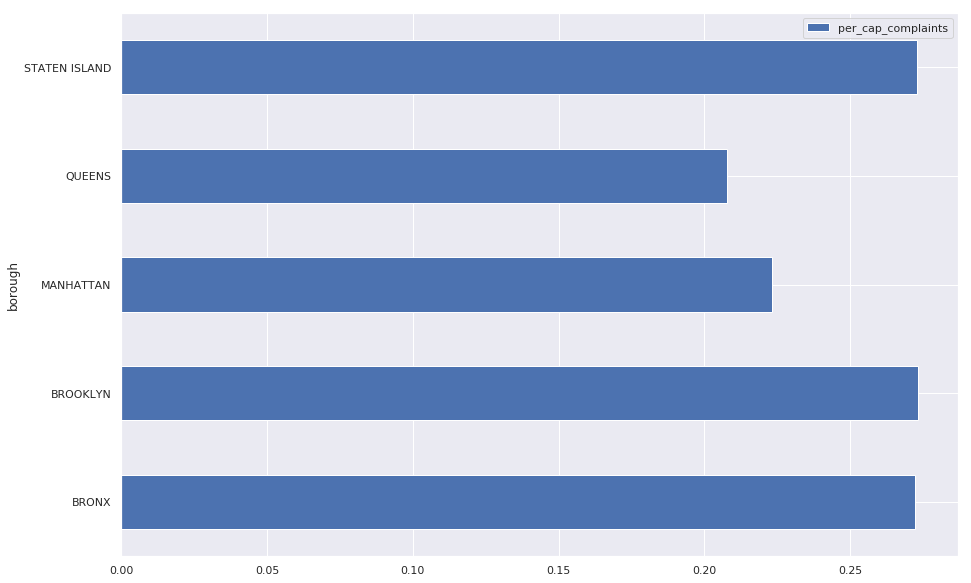

In [61]:
bor_pop_comp[['per_cap_complaints']].plot(kind='barh', figsize=(15,10))